In [39]:
import nibabel as nib
import numpy as np
import scipy as sp
import os
import csv
from nilearn.input_data import NiftiMapsMasker
import matplotlib.pyplot as plt

In [31]:
currentdir = os.getcwd()
datadir = os.path.join(currentdir,'OU_data','Without Bandpass')
maskdir = os.path.join(currentdir,'OU_data','Masks')
print(datadir)
print(maskdir)
import matplotlib.pyplot as plt

/Users/hstrey/Documents/programming/fMRI-analysis/OU_data/Without Bandpass
/Users/hstrey/Documents/programming/fMRI-analysis/OU_data/Masks


In [5]:
# get data files names
datafilenames = os.listdir(datadir)
print(datafilenames)

['niftiDATA_Subject003_Condition000.nii', 'niftiDATA_Subject002_Condition000.nii', 'niftiDATA_Subject001_Condition000.nii', 'niftiDATA_Subject005_Condition000.nii', 'niftiDATA_Subject004_Condition000.nii']


In [24]:
# create filenames for saving time series
time_series_names = []
for data_file in datafilenames:
    first_us = data_file.find('_')
    second_us = data_file.find('_',first_us+1)
    time_series_names.append(data_file[first_us+1:second_us])

print(time_series_names)

['Subject003', 'Subject002', 'Subject001', 'Subject005', 'Subject004']


In [13]:
# import masks
masks_img = nib.load(os.path.join(maskdir,'networks.nii'))

with open(os.path.join(maskdir,'networks.csv'), newline='') as f:
    reader = csv.reader(f)
    names_list = list(reader)

flatten = lambda l: [item for sublist in l for item in sublist]

network_list = flatten(names_list)[1:]
print(network_list)

['DefaultMode.MPFC (1,55,-3)', 'DefaultMode.LP (L) (-39,-77,33)', 'DefaultMode.LP (R) (47,-67,29)', 'DefaultMode.PCC (1,-61,38)', 'SensoriMotor.Lateral (L) (-55,-12,29)', 'SensoriMotor.Lateral (R) (56,-10,29)', 'SensoriMotor.Superior  (0,-31,67)', 'Visual.Medial (2,-79,12)', 'Visual.Occipital (0,-93,-4)', 'Visual.Lateral (L) (-37,-79,10)', 'Visual.Lateral (R) (38,-72,13)', 'Salience.ACC (0,22,35)', 'Salience.AInsula (L) (-44,13,1)', 'Salience.AInsula (R) (47,14,0)', 'Salience.RPFC (L) (-32,45,27)', 'Salience.RPFC (R) (32,46,27)', 'Salience.SMG (L) (-60,-39,31)', 'Salience.SMG (R) (62,-35,32)', 'DorsalAttention.FEF (L)  (-27,-9,64)', 'DorsalAttention.FEF (R)  (30,-6,64)', 'DorsalAttention.IPS (L)  (-39,-43,52)', 'DorsalAttention.IPS (R)  (39,-42,54)', 'FrontoParietal.LPFC (L)  (-43,33,28)', 'FrontoParietal.PPC (L)  (-46,-58,49)', 'FrontoParietal.LPFC (R)  (41,38,30)', 'FrontoParietal.PPC (R)  (52,-52,45)', 'Language.IFG (L) (-51,26,2)', 'Language.IFG (R) (54,28,1)', 'Language.pSTG (L) (

In [26]:
# extract all the time series and save them
masker = NiftiMapsMasker(maps_img=masks_img, standardize=True,
                         memory='nilearn_cache', verbose=5)

for data_file, ts_name in zip(datafilenames,time_series_names):
    epi_img = nib.load(os.path.join(datadir,data_file))
    time_series = masker.fit_transform(epi_img)
    np.save(os.path.join(datadir,ts_name),time_series)

[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image('/Users/hstrey/Documents/programming/fMRI-analysis/OU_data/Masks/networks.nii')
[Memory]4.7s, 0.1min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image('/Users/hstrey/Documents/programming/fMRI-analysis/OU_data/Masks/networks.nii')
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7fc5e8ef37b8>, <nilearn.input_data.nifti_maps_masker._ExtractionFunctor object at 0x7fc5e8ef3278>, 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x7fc5e86d0c50>,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'targ

/Users/hstrey/anaconda3/lib/python3.7/site-packages/nilearn/input_data/nifti_maps_masker.py:332: UserWarning: Persisting input arguments took 3.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


______________________________________________filter_and_extract - 66.5s, 1.1min
[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image('/Users/hstrey/Documents/programming/fMRI-analysis/OU_data/Masks/networks.nii')
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7fc610e2f898>, <nilearn.input_data.nifti_maps_masker._ExtractionFunctor object at 0x7fc610e2fb38>, 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x7fc5e86d0c50>,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from

/Users/hstrey/anaconda3/lib/python3.7/site-packages/nilearn/input_data/nifti_maps_masker.py:332: UserWarning: Persisting input arguments took 3.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


______________________________________________filter_and_extract - 67.5s, 1.1min
[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image('/Users/hstrey/Documents/programming/fMRI-analysis/OU_data/Masks/networks.nii')
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7fc5e8ef3e48>, <nilearn.input_data.nifti_maps_masker._ExtractionFunctor object at 0x7fc5e8ef3668>, 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x7fc5e86d0c50>,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from

/Users/hstrey/anaconda3/lib/python3.7/site-packages/nilearn/input_data/nifti_maps_masker.py:332: UserWarning: Persisting input arguments took 3.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


______________________________________________filter_and_extract - 67.8s, 1.1min
[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image('/Users/hstrey/Documents/programming/fMRI-analysis/OU_data/Masks/networks.nii')
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7fc5e8ef3358>, <nilearn.input_data.nifti_maps_masker._ExtractionFunctor object at 0x7fc5e8ef3438>, 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x7fc5e86d0c50>,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from

/Users/hstrey/anaconda3/lib/python3.7/site-packages/nilearn/input_data/nifti_maps_masker.py:332: UserWarning: Persisting input arguments took 3.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


In [28]:
time_series = np.load(os.path.join(datadir,time_series_names[0]+".npy"))

In [29]:
mpfc = time_series[:,0]
llp = time_series[:,1]
rlp = time_series[:,2]
pcc = time_series[:,3]

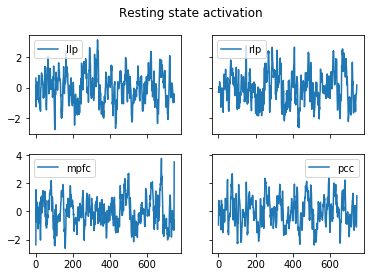

In [32]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
f.suptitle('Resting state activation')
ax1.plot(llp, label="llp")
ax1.legend()
ax2.plot(rlp,label = "rlp")
ax2.legend()
ax3.plot(mpfc,label = "mpfc")
ax3.legend()
ax4.plot(pcc,label = "pcc")
ax4.legend()

In [33]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

def OUcross(data1,data2):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A,x1_dA, x1_tau ,x1_dtau= OUresult(x1,0.802)
    x2_A, x2_dA, x2_tau ,x2_dtau= OUresult(x2,0.802)
    return (x1_A - x2_A)/x2_A, np.sqrt(x1_dA**2 + x1_A**2*x2_dA**2/x2_A**4)

mean:  7.012311e-09
var:  1.0
N:  748
relaxation time: 4.951798624556315 SD tau 0.7158666195196934
A  1.0555732603661954 SD A 0.14011353256241396


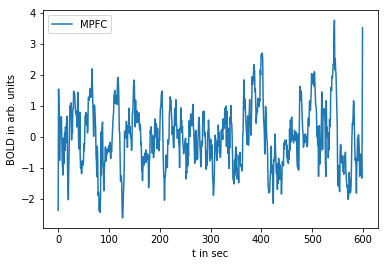

In [34]:
print("mean: ",mpfc.mean())
print("var: ",mpfc.std()**2)
N=len(mpfc)
print("N: ",N)
mpfc_A,mpfc_sA, mpfc_tau, mpfc_dtau = OUresult(mpfc,0.802)
print("relaxation time:",mpfc_tau, "SD tau", mpfc_dtau)
print("A ",mpfc_A,"SD A",mpfc_sA)
mpfc_norm=mpfc/np.sqrt(mpfc_A)
t = np.arange(N)*0.802 # tR = 0.802 sec
plt.plot(t,mpfc,label="MPFC")
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")
plt.legend()

mean:  1.2749657e-09
var:  1.0
N:  748
relaxation time: 7.989069847219934 SD tau 1.3656366756565408
A  1.0009735825910855 SD A 0.16274570699835292
0.9995135


Text(0, 0.5, 'BOLD in arb. units')

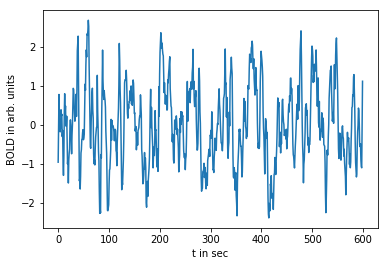

In [35]:
print("mean: ",pcc.mean())
print("var: ",pcc.std()**2)
N=len(pcc)
print("N: ",N)
pcc_A,pcc_sA, pcc_tau, pcc_dtau = OUresult(pcc,0.802)
print("relaxation time:",pcc_tau, "SD tau", pcc_dtau)
print("A ",pcc_A,"SD A",pcc_sA)
pcc_norm=pcc/np.sqrt(pcc_A)
print(pcc_norm.std())
plt.plot(t,pcc)
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")

mean:  -1.5299587e-08
var:  1.0000002384185933
N:  748
relaxation time: 5.685660149842419 SD tau 0.8342615652077847
A  0.9922847955113431 SD A 0.13591423552199994
1.0038801


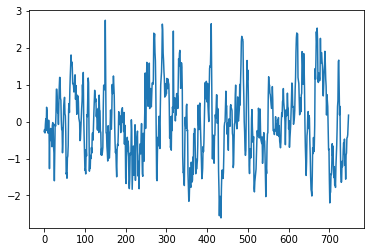

In [36]:
plt.plot(rlp)
print("mean: ",rlp.mean())
print("var: ",rlp.std()**2)
N=len(rlp)
print("N: ",N)
rlp_A,rlp_sA, rlp_tau, rlp_dtau = OUresult(rlp,0.802)
print("relaxation time:",rlp_tau, "SD tau", rlp_dtau)
print("A ",rlp_A,"SD A",rlp_sA)
rlp_norm=rlp/np.sqrt(rlp_A)
print(rlp_norm.std())

mean:  -8.92476e-09
var:  1.0
N:  748
relaxation time: 6.197271489293394 SD tau 0.9460386087112785
A  0.9967438360588914 SD A 0.1427644595292449
1.0016321


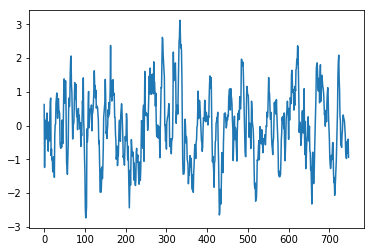

In [37]:
plt.plot(llp)
print("mean: ",llp.mean())
print("var: ",llp.std()**2)
N=len(llp)
print("N: ",N)
llp_A,llp_sA, llp_tau, llp_dtau = OUresult(llp,0.802)
print("relaxation time:",llp_tau, "SD tau", llp_dtau)
print("A ",llp_A,"SD A",llp_sA)
llp_norm=llp/np.sqrt(llp_A)
print(llp_norm.std())

In [38]:
print("MPFC:PCC",OUcross(mpfc_norm,pcc_norm))
print("MPFC:RLP",OUcross(mpfc_norm,rlp_norm))
print("MPFC:LLP",OUcross(mpfc_norm,llp_norm))
print("PCC:RLP",OUcross(pcc_norm,rlp_norm))
print("PCC:LLP",OUcross(pcc_norm,llp_norm))
print("RLP:LLP",OUcross(rlp_norm,llp_norm))
print("Pearson MPFC:PCC",sp.stats.pearsonr(mpfc_norm,pcc_norm))
print("Pearson MPFC:RLP",sp.stats.pearsonr(mpfc_norm,rlp_norm))
print("Pearson MPFC:LLP",sp.stats.pearsonr(mpfc_norm,llp_norm))
print("Pearson PCC:RLP",sp.stats.pearsonr(pcc_norm,rlp_norm))
print("Pearson PCC:LLP",sp.stats.pearsonr(pcc_norm,llp_norm))
print("Pearson RLP:LLP",sp.stats.pearsonr(rlp_norm,llp_norm))

MPFC:PCC (2.658645271571127, 0.6768337760251653)
MPFC:RLP (1.4653056248454117, 0.5033158777762963)
MPFC:LLP (0.8164545779689529, 0.436612309685484)
PCC:RLP (2.7627488952217196, 0.6869700216118552)
PCC:LLP (2.1858703789589975, 0.6791014021463728)
RLP:LLP (6.6612640256448685, 0.9412973816519872)
Pearson MPFC:PCC (0.5650582, 2.551537999999214e-64)
Pearson MPFC:RLP (0.42555624, 2.9469233928659496e-34)
Pearson MPFC:LLP (0.32014707, 2.741834465466495e-19)
Pearson PCC:RLP (0.5814242, 7.355296995393175e-69)
Pearson PCC:LLP (0.53573936, 8.583205531860004e-57)
Pearson RLP:LLP (0.77184916, 7.202975634701998e-149)
